In [3]:
import numpy as np
import exoplanet as xo
from astropy import units as u
import math
import arviz as az
import pymc3 as pm
import pymc3_ext as pmx
import matplotlib.pyplot as plt
from collections import OrderedDict

R_sun = 696340000 * u.m
M_sun = 1.989 * 10 ** 30 * u.kg
R_earth = 6371000 * u.m

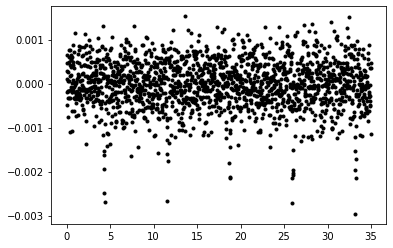

In [4]:
random = np.random.default_rng(123)
num_transits = 4
t = np.arange(0, 35, 0.02)
yerr = 5e-4
t0 = 4.35
t1 = 33.2
period = (t1 - t0) / num_transits
u = [0.3,0.2]
r = 0.04
b = 0.35

# Set up a Keplerian orbit for the planet
orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
y = (xo.LimbDarkLightCurve(u[0], u[1]).get_light_curve(orbit=orbit, r=r, t=t)[:, 0]).eval()
y += yerr * random.normal(size=len(y))
     
plt.plot(t,y,'k.');

In [5]:
datasets = OrderedDict([])
datasets['wavelength_1'] = (t,y,yerr,r**2,u)

In [9]:
with pm.Model() as model:
    # Stellar parameters
    # -----------------
    m_s = pm.Normal('m_s', 1, 0.05)
    r_s = pm.Normal('r_s', 1, 0.05)
    # Orbital parameters
    # -----------------
    t0 = pm.Normal("t0", mu=4.35, sigma=1.0)
    p = pm.Normal('P', 7.2, 0.5)  # If log_p, use Deterministic here : pm.Deterministic(“period”, tt.exp(log_period))
    b = xo.distributions.ImpactParameter("b", ror=0.04, testval=0.35)
    # b=pm.Deterministic(‘b’,tt.as_tensor_variable(0))

    # Keplerian orbit
    # ---------------
    orbit = xo.orbits.KeplerianOrbit(period=p, t0=t0, r_star=r_s, b=b, m_star=m_s)
#     pm.Deterministic('a', orbit.a)
#     pm.Deterministic('i', orbit.incl * 180 / np.pi)
#     pm.Deterministic('a/r_s', orbit.a / orbit.r_star)
    # Loop over the instruments
    # -------------------------
    # depth = []
    for n, (name, (x, y, yerr, d, ldc)) in enumerate(datasets.items()):
        # We define the per-instrument parameters in a submodel so that we don’t have to prefix the names manually
#         with pm.Model(name=name, model=model):
        # The limb darkening #It’s the same filter in this case
        u = xo.QuadLimbDark(f'{name}_u', testval = np.array(ldc))
        star = xo.LimbDarkLightCurve(u)
        # The radius ratio
        depth = pm.Uniform(f'{name}_depth', 0.001, 0.01, testval = d)  # Prior normal sur log(param) = prior uniform sur param
        # depth.append(depths)
        # depth=pm.Deterministic(“depth”,tt.as_tensor_variable(4e-3))
        ror = pm.Deterministic(f'{name}_ror', star.get_ror_from_approx_transit_depth(depth, b))
        r_p = pm.Deterministic(f'{name}_r_p', ror * r_s)  # In solar radius
#       r = pm.Deterministic('r', r_p * 1 / R_sun)
        # starry light-curve
        light_curves = star.get_light_curve(orbit=orbit, r=r_p, t=x)
        transit = pm.Deterministic(f'{name}_light_curves', pm.math.sum(light_curves, axis=-1))
        mu = pm.Deterministic(f'{name}_mu', transit)
        # Likelihood function
        pm.Normal(f'{name}_obs', mu = mu, sd = yerr, observed = y)
        # Maximum a posteriori
        # --------------------
            
    opt = pmx.optimize(start=model.test_point)
    opt = pmx.optimize(start=opt, vars=[depth,u])
    # opt = pmx.optimize(start=opt, vars=[depth[1]])
    
    trace = pmx.sample(
            tune=4000,
            draws=8000,
            start=opt,
            cores=12,
            chains=4,
            target_accept=0.9,
        )

optimizing logp for variables: [wavelength_1_depth, wavelength_1_u, b, P, t0, r_s, m_s]


message: Desired error not necessarily achieved due to precision loss.
logp: 10721.677115545592 -> 10779.843919243636
optimizing logp for variables: [wavelength_1_u, wavelength_1_depth]


message: Optimization terminated successfully.
logp: 10779.843919243636 -> 10779.843919243636
/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/pymc3_ext/sampling/sampling.py:109: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Multiprocess sampling (4 chains in 12 jobs)
NUTS: [wavelength_1_depth, wavelength_1_u, b, P, t0, r_s, m_s]


/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 4_000 tune and 8_000 draw iterations (16_000 + 32_000 draws total) took 195 seconds.
The number of effective samples is smaller than 25% for some parameters.


Text(0, 0.5, 'relative flux')

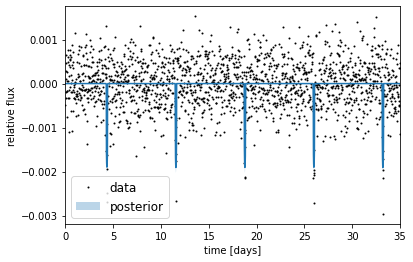

In [18]:
# Plot the results
q16, q50, q84 = np.percentile(
    trace["wavelength_1_light_curves"], [16, 50, 84], axis=(0)
)
plt.plot(t, y, ".k", ms=2, label="data")
plt.plot(t, q50)
plt.fill_between(t, q16, q84, alpha=0.3, label="posterior")
plt.xlim(0.0, 35)
plt.legend(fontsize=12, loc=3)
plt.xlabel("time [days]")
plt.ylabel("relative flux")

In [12]:
model

In [13]:
opt

{'m_s': array(0.99796947),
 'r_s': array(1.00604269),
 't0': array(4.35194369),
 'P': array(7.21153839),
 'b_impact__': array(-0.33400275),
 'wavelength_1_u_quadlimbdark__': array([-0.91409414,  0.00407114]),
 'wavelength_1_depth_interval__': array(-2.15759331),
 'b': array(0.43395769),
 'wavelength_1_u': array([ 0.53603076, -0.00108891]),
 'wavelength_1_depth': array(0.00193261),
 'wavelength_1_ror': array(0.04094715),
 'wavelength_1_r_p': array(0.04119458),
 'wavelength_1_light_curves': array([0., 0., 0., ..., 0., 0., 0.]),
 'wavelength_1_mu': array([0., 0., 0., ..., 0., 0., 0.])}